In [ ]:
#(1)Copy Dataset
from google.colab import drive
import os

drive.mount('/content/drive')

#Konfigurasi Path
source = '/content/drive/MyDrive/Colab Notebooks/dataset'
dest = '/content/dataset'

if os.path.exists(source):
    print(f"Menyalin data dari {source}")
    !cp -r "$source" "$dest"

    if os.path.exists(dest):
        print(f"Isi folder dataset: {os.listdir(dest)}")
else:
    print(f"Error")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Menyalin data dari /content/drive/MyDrive/Colab Notebooks/dataset
Isi folder dataset: ['LyricsWav', 'dataset', 'readme.txt', 'UnvoicedFrameLabel', 'UndividedWavfile', 'Lyrics', 'Wavfile', 'PitchLabel', 'vocal-nonvocalLabel']


In [ ]:
#(2)Untuk menentukan target foldernya yang benar yaitu Wavfile dan PitchLabel
import glob

base_dataset_path = '/content/dataset'
target_wav_dir = os.path.join(base_dataset_path, 'Wavfile')
target_label_dir = os.path.join(base_dataset_path, 'PitchLabel')

print(f"Target Audio Folder: {target_wav_dir}")
if os.path.exists(target_wav_dir):
    wav_files = glob.glob(os.path.join(target_wav_dir, "*.wav"))
    print(f"Jumlah file audio : {len(wav_files)}")

print(f"Contoh file: {os.path.basename(wav_files[0])}")
wav_dir = target_wav_dir
label_dir = target_label_dir

Target Audio Folder: /content/dataset/Wavfile
Jumlah file audio : 1000
Contoh file: bug_3_05.wav


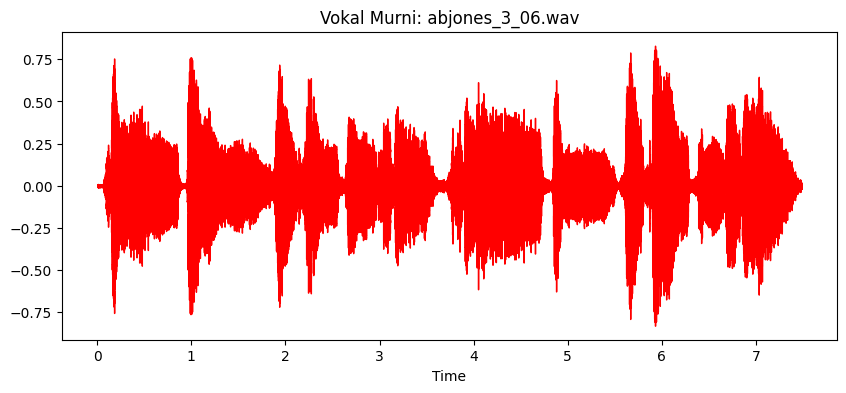

In [ ]:
#(3)
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

#ambil 1 file contoh
example_file = wav_files[2]

#Load (Stereo)
y, sr = librosa.load(example_file, sr=16000, mono=False)

#Pisahkan Channel (0: Musik, 1: Vokal)
vocal_audio = y[1]

#Tampilkan
plt.figure(figsize=(10, 4))
librosa.display.waveshow(vocal_audio, sr=sr, color='red')
plt.title(f"Vokal Murni: {os.path.basename(example_file)}")
plt.show()

#Play
ipd.Audio(vocal_audio, rate=sr)

In [ ]:
#(4)
#Fungsi Matematika Konversi Hz <-> Bins

#CREPE Architecture
CENTS_PER_BIN = 20  #Setiap bin mewakili 20 cents (sangat presisi)
PITCH_BINS = 360    #Total kelas output(C1 - B7)

#Rumus: 1200 * log2(f / 10)
def to_local_average_cents(frequency): #Mengubah Hz menjadi Cents relative terhadap 10Hz.
    if frequency == 0:
        return 0
    return 1200 * np.log2(frequency / 10.0)  #pakai logaritma basis 2 karena musik bersifat logaritmik()

def get_bin_index(frequency): #Mengubah Hz menjadi index Bin (0 - 359).
    if frequency <= 0:
        return 0 # Bin 0 untuk silence/unvoiced

    cents = to_local_average_cents(frequency) #hitung cents
    bin_idx = int(np.round(cents / CENTS_PER_BIN))#masukkan ke bin()

    #Clip agar tidak keluar batas idx (0 sampai 359)
    return np.clip(bin_idx, 0, PITCH_BINS - 1)

print(f"Contoh: Nada A4 (440Hz) masuk ke Bin nomor: {get_bin_index(440)}")

Contoh: Nada A4 (440Hz) masuk ke Bin nomor: 328


In [ ]:
#cents itu seperti contoh jarak dari nada C ke C# seperti 1meter, terlalu jauh untuk mengukur fales
#atau nada yang meleset sedikit. Jadi centsnya dari 1 meter = 100 cm, memecah 1 nada(100cents) menjadi
#5 loker yang kecil dimana per lokernya itu 20 cents. Untuk mengukur ketepatan nada. Kalau suara melesetnya
#+10 cents berarti sedikit tinggi dari nada aslinya(sharp), tapi belum sampai jadi nada C#

#Bin = seperti 360 loker. Potong potong range frekuensi suara menjadi 360 bagian.
#untuk menebak masuk ke loker yang no. berapa?
#1 loker(bin) = 20 cents

#jadinya modelnya bisa mendeteksi nada dengan 5x lebih teliti daripada tuner biasa.

#pakai Log Basis 2 (log2) karena basis perubahannya adalah angka 2 (Setiap naik oktaf = frekuensi * 2).
#Logaritma bertugas "meratakan" grafik yang melengkung tajam (eksponensial) menjadi garis lurus (linear) supaya mudah dihitung oleh komputer.
#tanpa Log: 110, 220, 440, 880(Jaraknya berantakan) ; dengan Log2: 1, 2, 3, 4 (Jaraknya rapi, masing-masing 1 oktaf)

In [ ]:
#(5)
#Main Preprocessing Loop
import numpy as np

wav_dir = '/content/dataset/Wavfile'
label_dir = '/content/dataset/PitchLabel'

print(f"Target Audio: {wav_dir}")
print(f"Target Label: {label_dir}")

X_data = [] # Audio chunks(wadah untuk potongan audio ; input)
y_data = [] # Label bins(wadah untuk label nada ; kunci jawabannya)

#Cari semua file wav
wav_files = glob.glob(os.path.join(wav_dir, "*.wav"))
print(f"Total file ditemukan: {len(wav_files)}")

# Konstanta Model
FRAME_SIZE = 1024 #setiap potongan audio panjangnya 1024 samples.
HOP_SIZE = 160    # windownya bergeser setiap (sekitar 10ms).
sr_target = 16000 # Sample rate wajib

count = 0
matches_found = 0

for wav_file in wav_files:
    filename = os.path.basename(wav_file)
    file_id = filename.split('.')[0]

    #Cari file label pasangannya (.pv)
    label_file = os.path.join(label_dir, file_id + ".pv")

    #Cek case sensitive (jaga-jaga kalau ada .PV)
    if not os.path.exists(label_file):
        label_file = os.path.join(label_dir, file_id + ".PV")

    #tidak ketemu, skip
    if not os.path.exists(label_file):
        print(f"Skip: Label untuk {filename} tidak ditemukan.")
        continue

    matches_found += 1

    #Load Audio (Vokal Saja - Channel 1)
    try:
        y, sr = librosa.load(wav_file, sr=sr_target, mono=False) #load audio didalam Stereo(2 channel)
        vocal = y[1] # Ambil channel kanan (Vokal)
    except Exception as e:
        print(f"Error reading {filename}: {e}")
        continue

    #Load Label
    try:
        with open(label_file, 'r') as f:
            freqs = [float(line.strip()) for line in f.readlines()]
    except:
        continue

    #Slicing Loop
    n_frames = len(freqs)

    for i in range(n_frames):
        start_sample = i * HOP_SIZE
        end_sample = start_sample + FRAME_SIZE

        #memastikan tidak out of bounds
        if end_sample > len(vocal):
            break

        current_freq = freqs[i]

        #FILTER: Hanya ambil frame yang bersuara (freq > 0)
        #buang frame diam (unvoiced) agar model fokus belajar nada
        if current_freq > 0:
            audio_chunk = vocal[start_sample:end_sample]

            #Normalisasi sederhana ; membuat volume suaranya seragam(-1 sampai 1)
            max_val = np.max(np.abs(audio_chunk))
            if max_val > 0:
                audio_chunk = audio_chunk / max_val

            #Convert Freq ke Bin Index
            bin_label = get_bin_index(current_freq)

            X_data.append(audio_chunk)
            y_data.append(bin_label)

    count += 1
    if count % 50 == 0:
        print(f"Processed {count}/{len(wav_files)} songs...", end='\r')

#Convert ke Numpy
X_data = np.array(X_data, dtype=np.float32)
y_data = np.array(y_data, dtype=np.longlong)

print(f"File cocok ditemukan: {matches_found} dari {len(wav_files)}")
print(f"Total Sampel Training (Frames): {X_data.shape[0]}")
print(f"Shape X: {X_data.shape}")

Target Audio: /content/dataset/Wavfile
Target Label: /content/dataset/PitchLabel
Total file ditemukan: 1000
File cocok ditemukan: 1000 dari 1000
Total Sampel Training (Frames): 280400
Shape X: (280400, 1024)


In [ ]:
#(6) Simpan Data hasil preprocessingnya
save_path = '/content/drive/MyDrive/DeepLearning_Project/processed_data'
if not os.path.exists(save_path):
    os.makedirs(save_path)

print(f"Menyimpan data ke G Drive: {save_path}")
np.save(os.path.join(save_path, 'X_train.npy'), X_data)
np.save(os.path.join(save_path, 'y_train.npy'), y_data)

Menyimpan data ke G Drive: /content/drive/MyDrive/DeepLearning_Project/processed_data


In [ ]:
#(1.1)
##Load Dataset Langsung dari Drive
#(untuk shortcut supaya setiap membuka atau me restart runtime dan melanjutkan codenya di colab tidak perlu mengulang proses preprocessing
#(memotong audio, convert ke spectrogram, dll) yang memakan waktu lama. Jadi cukup memanggil hasil olahan yang sudah disimpan ("Save Data") sebelumnya.
from google.colab import drive #import modul khusus milik Google Colab untuk menghubungkan (mount) penyimpanan cloud Google Drive ke dalam sistem file Linux di Colab.
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import os

#Connect Drive(supaya Colab boleh membaca dan menulis file di acc Google Drive))
drive.mount('/content/drive')

#Load Data Numpy(dataset yang sudah matang)
save_path = '/content/drive/MyDrive/DeepLearning_Project/processed_data'
X_data = np.load(os.path.join(save_path, 'X_train.npy'))
y_data = np.load(os.path.join(save_path, 'y_train.npy'))
#membaca file dari hardisk Drive dan memasukkannya ke RAM (X_data dan y_data).
#Menggabungkan alamat folder dengan nama file (X_train.npy) secara otomatis.

print(f"Data Loaded: {X_data.shape[0]} samples.")
if os.path.exists(save_path):
    print(f"Folder ditemukan: {save_path}")
    print("Isi folder:", os.listdir(save_path))
else:
    print(f"ERROR")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data Loaded: 280400 samples.
Folder ditemukan: /content/drive/MyDrive/DeepLearning_Project/processed_data
Isi folder: ['X_train.npy', 'y_train.npy']


In [ ]:
#(7)
#Setup Dataset & DataLoader
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training akan berjalan di: {device}")

#Split Data (80% Training, 20% Validasi)
#bagi supaya tahu apakah model benar-benar belajar atau cuma menghafal
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

#Konversi ke Tensor PyTorch
#tambah dimensi channel (N, 1024) -> (N, 1, 1024) untuk CNN
X_train_torch = torch.tensor(X_train).unsqueeze(1).to(device)
y_train_torch = torch.tensor(y_train).long().to(device)

X_val_torch = torch.tensor(X_val).unsqueeze(1).to(device)
y_val_torch = torch.tensor(y_val).long().to(device)

#Buat DataLoader
BATCH_SIZE = 128

train_dataset = TensorDataset(X_train_torch, y_train_torch)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val_torch, y_val_torch)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Training akan berjalan di: cuda


In [ ]:
#(8)
#Definisi Model CNN (VocalTuna) ; menggunakan 1D CNN(One Dimensional CNN)
import torch.nn as nn

class VocalTunaNet(nn.Module):
    def __init__(self):
        super(VocalTunaNet, self).__init__()
        #1.Feature Extractor (Convolutional Layers)
        #Input: [Batch, 1, 1024]

        # Layer 1: Menangkap fitur dasar gelombang(Output Channel: 128 (Model membuat 128 filter berbeda untuk melihat audio dari berbagai sudut pandang))
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 128, kernel_size=51, stride=4, padding=25),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        #Layer 2: Menangkap pola yang lebih kompleks(input : 128 ; output : 128)
        #memperdalam pemahaman fitur yang didapat dari Layer 1.
        self.conv2 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=51, stride=1, padding=25),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        #Layer 3 (output : 256)
        #Semakin dalam layernya, ukuran data makin pendek (karena MaxPool), tapi fiturnya makin tebal (banyak channel) karena model mempelajari pola yang lebih kompleks/abstrak.
        self.conv3 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=51, stride=1, padding=25),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        #Layer 4 (output : 512)
        #layer ekstraksi fitur terakhir. data sudah sangat terkompresi tapi sangat kaya informasi.
        self.conv4 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=51, stride=1, padding=25),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        #Tugasnya menerima audio mentah dan mengubahnya menjadi fitur-fitur penting (pola gelombang, tekstur suara, frekuensi dominan).

        #2.Classifier (Fully Connected)
        #mengambil fitur dari feature extractor tadi, lalu menebak: "Ini masuk ke nada (Bin) nomor berapa dari 0 sampai 359?"
        # Setelah Conv4 dan MaxPool, dimensi data menjadi [Batch, 512, 16] (kira-kira)
        #flatten menjadi satu vektor panjang (8192 features) dan merangkumnya menjadi 360 angka.
        self.fc = nn.Linear(512 * 16, 360) # 360 Output Bins ; Angka tertinggi adalah tebakan modelnya.

        #Dropout untuk mencegah overfitting
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        #Flatten
        x = x.view(x.size(0), -1)

        x = self.dropout(x)
        x = self.fc(x)
        return x

#Inisialisasi Modelnya
model = VocalTunaNet().to(device)
print(model)

VocalTunaNet(
  (conv1): Sequential(
    (0): Conv1d(1, 128, kernel_size=(51,), stride=(4,), padding=(25,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(128, 128, kernel_size=(51,), stride=(1,), padding=(25,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(128, 256, kernel_size=(51,), stride=(1,), padding=(25,))
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv1d(256, 512, kernel_size=(51,), stride=(1,), padding=(25,))
    (1): BatchNorm1d(5

In [ ]:
#untuk bagian Classifier : (input : 1024 -> layer1 (/4) -> 256 ->layer1(/2) -> 128 ->layer2 (/2) -> 64 ->layer3 (/2) -> 32 ->layer4(/2) -> 16)
#output akhir CNN modelnya, ukurannya adalah 512 Channel * 16 Panjang Data.

In [ ]:
#(9)
#(Relaxed Accuracy)
import torch

def check_relaxed_accuracy(loader, model, tolerance=3):
    model.eval() # Mode Ujian (Matikan Dropout)
    correct = 0
    total = 0

    with torch.no_grad(): # Jangan hitung gradien (hemat memori)
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            #Hitung selisih tebakan vs kunci jawaban
            diff = torch.abs(predicted - labels)

            #kalau selisih <= toleransi, anggap benar
            correct += (diff <= tolerance).sum().item()
            total += labels.size(0)

    return 100 * correct / total

In [ ]:
#Menghitung akurasi dengan toleransi.
#kalau tebakan model meleset <= 3 bin (±50 cents), tetap dianggap BENAR. karena dalam musik, sedikit meleset (fales tipis) masih bisa dimaklumi.

In [ ]:
#(10) Training Loop Final
import torch.optim as optim

#Setup
criterion = nn.CrossEntropyLoss() # Loss untuk klasifikasi
optimizer = optim.Adam(model.parameters(), lr=0.0005)#Kecepatan belajar

EPOCHS = 50
best_acc = 0.0

for epoch in range(EPOCHS):
    model.train() #Mode latihan atau belajar
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad() #Reset gradien ; catatan error sebelumnya
        outputs = model(inputs) #Forward pass(menebak)
        loss = criterion(outputs, labels) #Hitung Error

        #Proses Belajar (Backpropagation)
        loss.backward() #Backpropagation(evaluasi)
        optimizer.step() #Update bobotnya, otaknya(optimization)

        running_loss += loss.item()

        #hitung Akurasi Training(Strict) untuk monitoring
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    #fase validation(mode ujian)
    val_acc = check_relaxed_accuracy(val_loader, model, tolerance=3)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    #Save modelnya
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/DeepLearning_Project/vocal_tuna_best.pth')
        print("Model Saved!")

print(f"Best Validation Accuracy: {best_acc:.2f}%")

Epoch [1/50] | Loss: 3.1935 | Train Acc: 9.65% | Val Acc: 43.94%
Model Saved!
Epoch [2/50] | Loss: 3.1370 | Train Acc: 10.79% | Val Acc: 45.01%
Model Saved!
Epoch [3/50] | Loss: 3.0778 | Train Acc: 11.95% | Val Acc: 46.74%
Model Saved!
Epoch [4/50] | Loss: 3.0106 | Train Acc: 13.61% | Val Acc: 47.61%
Model Saved!
Epoch [5/50] | Loss: 2.9401 | Train Acc: 15.26% | Val Acc: 48.65%
Model Saved!
Epoch [6/50] | Loss: 2.8587 | Train Acc: 17.32% | Val Acc: 51.06%
Model Saved!
Epoch [7/50] | Loss: 2.7690 | Train Acc: 19.52% | Val Acc: 52.55%
Model Saved!
Epoch [8/50] | Loss: 2.6804 | Train Acc: 21.86% | Val Acc: 54.37%
Model Saved!
Epoch [9/50] | Loss: 2.5889 | Train Acc: 24.09% | Val Acc: 55.79%
Model Saved!
Epoch [10/50] | Loss: 2.4950 | Train Acc: 26.60% | Val Acc: 56.84%
Model Saved!
Epoch [11/50] | Loss: 2.3954 | Train Acc: 29.13% | Val Acc: 59.62%
Model Saved!
Epoch [12/50] | Loss: 2.2974 | Train Acc: 31.66% | Val Acc: 60.55%
Model Saved!
Epoch [13/50] | Loss: 2.2014 | Train Acc: 34.24% |

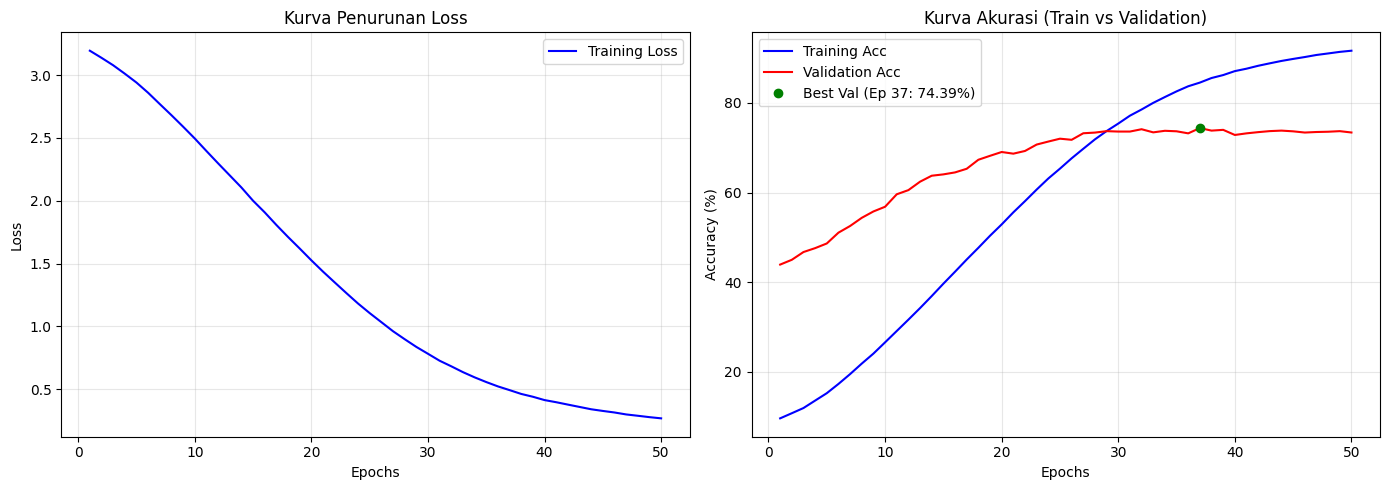

In [ ]:
#(11)
import matplotlib.pyplot as plt

loss_history = [
    3.1935, 3.1370, 3.0778, 3.0106, 2.9401, 2.8587, 2.7690, 2.6804, 2.5889, 2.4950,
    2.3954, 2.2974, 2.2014, 2.1053, 1.9998, 1.9072, 1.8069, 1.7113, 1.6196, 1.5257,
    1.4357, 1.3501, 1.2652, 1.1822, 1.1059, 1.0339, 0.9618, 0.8983, 0.8369, 0.7821,
    0.7268, 0.6824, 0.6360, 0.5946, 0.5571, 0.5225, 0.4929, 0.4625, 0.4401, 0.4136,
    0.3966, 0.3777, 0.3591, 0.3405, 0.3272, 0.3149, 0.2994, 0.2888, 0.2778, 0.2683
]

train_acc_history = [
    9.65, 10.79, 11.95, 13.61, 15.26, 17.32, 19.52, 21.86, 24.09, 26.60,
    29.13, 31.66, 34.24, 36.92, 39.68, 42.35, 45.07, 47.68, 50.37, 52.90,
    55.59, 58.09, 60.67, 63.14, 65.34, 67.64, 69.77, 71.87, 73.72, 75.39,
    77.15, 78.53, 80.01, 81.31, 82.57, 83.71, 84.53, 85.55, 86.21, 87.09,
    87.63, 88.28, 88.83, 89.36, 89.81, 90.23, 90.69, 91.03, 91.38, 91.64
]

val_acc_history = [
    43.94, 45.01, 46.74, 47.61, 48.65, 51.06, 52.55, 54.37, 55.79, 56.84,
    59.62, 60.55, 62.43, 63.76, 64.06, 64.50, 65.31, 67.32, 68.20, 69.05,
    68.68, 69.28, 70.71, 71.38, 72.02, 71.77, 73.23, 73.38, 73.70, 73.61,
    73.61, 74.13, 73.43, 73.78, 73.67, 73.21, 74.39, 73.82, 73.99, 72.85,
    73.21, 73.48, 73.71, 73.82, 73.66, 73.39, 73.51, 73.57, 73.70, 73.40
]

epochs = range(1, len(loss_history) + 1)

plt.figure(figsize=(14, 5))

#Grafik 1: Training Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_history, 'b-', label='Training Loss')
plt.title('Kurva Penurunan Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.legend()

#Grafik 2: Akurasi (Train vs Val)
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_history, 'b-', label='Training Acc')
plt.plot(epochs, val_acc_history, 'r-', label='Validation Acc')

#Tandai Akurasi yang Terbaik (Epoch 37)
best_epoch = 37
best_val = 74.39
plt.plot(best_epoch, best_val, 'go', label=f'Best Val (Ep {best_epoch}: {best_val}%)')

plt.title('Kurva Akurasi (Train vs Validation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

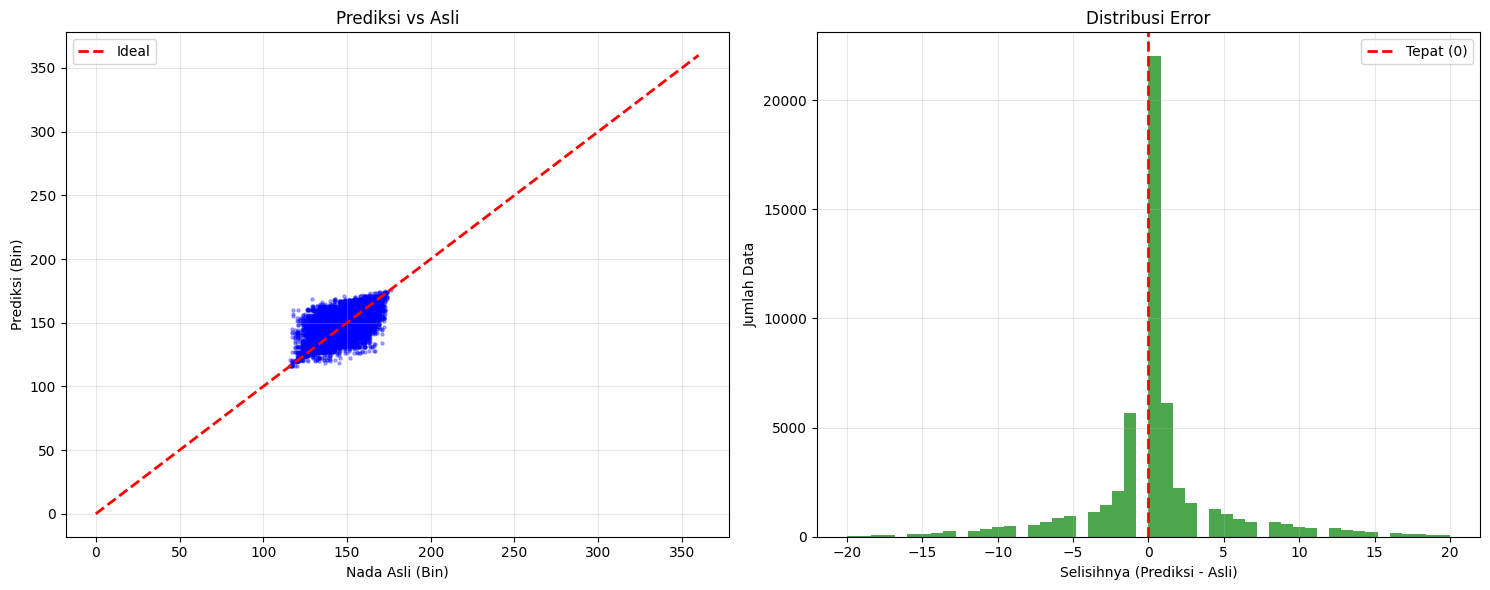

In [ ]:
#(12)Visualisasi
import torch

#Ambil Data
model.eval()
preds, targets = [], []

with torch.no_grad():
    for x, y in val_loader:
        out = model(x)
        preds.extend(torch.argmax(out, dim=1).cpu().numpy())
        targets.extend(y.cpu().numpy())

preds = np.array(preds)
targets = np.array(targets)
errors = preds - targets

#Buat Grafik (Kiri: Scatter, Kanan: Histogram)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

#Scatter Plot
ax1.scatter(targets, preds, alpha=0.3, color='blue', s=5)
ax1.plot([0, 360], [0, 360], 'r--', linewidth=2, label='Ideal') #Garis diagonal
ax1.set_title("Prediksi vs Asli")
ax1.set_xlabel("Nada Asli (Bin)"); ax1.set_ylabel("Prediksi (Bin)")
ax1.legend()
ax1.grid(True, alpha=0.3)

#Histogram Error
ax2.hist(errors, bins=50, color='green', alpha=0.7, range=(-20, 20))
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Tepat (0)')
ax2.set_title("Distribusi Error")
ax2.set_xlabel("Selisihnya (Prediksi - Asli)"); ax2.set_ylabel("Jumlah Data")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

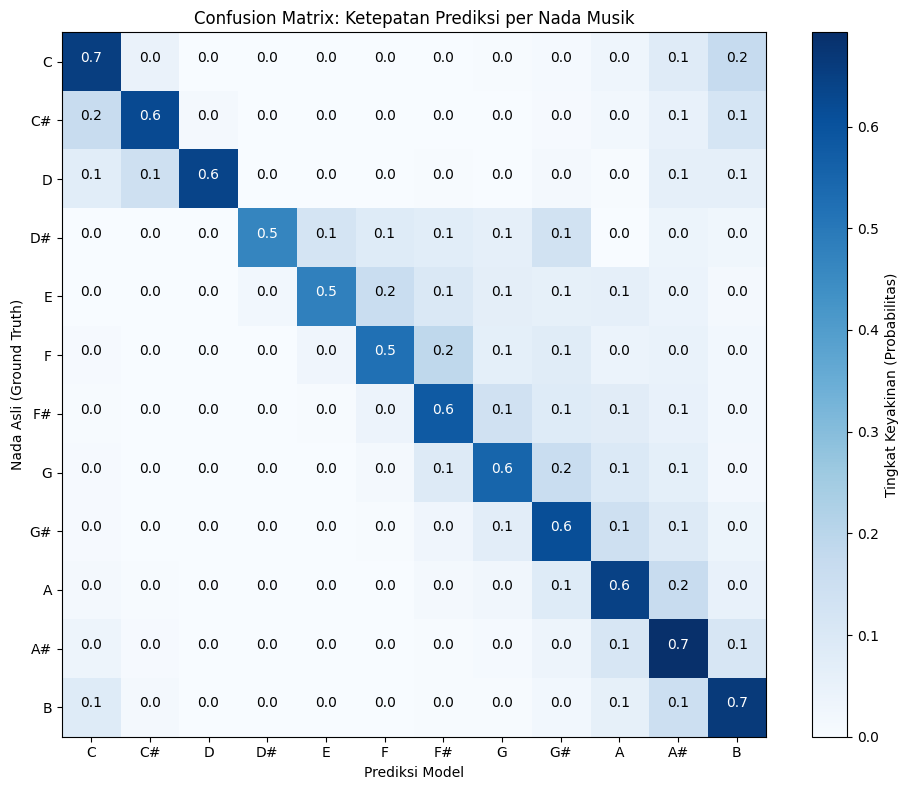

In [ ]:
#(13)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import torch

#Definisi 12 Nada Musik
NOTES = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

def bin_to_chroma(bin_idx): #Mengubah Bin Index (0-359) menjadi Index Nada (0-11)
    if bin_idx == 0: return 0 #Handle Silence

    #Bin ke Frekuensi
    cents = bin_idx * 20
    freq = 10 * (2 ** (cents / 1200.0))

    #Frekuensi ke MIDI Number
    #Rumus: 69 + 12 * log2(f / 440)
    midi_number = 69 + 12 * np.log2(freq / 440.0)

    #MIDI ke Chroma (0-11)
    #pakai Modulo 12 agar semua oktaf (C3, C4, C5) jadi satu
    return int(np.round(midi_number)) % 12

#Kumpulkan Data & Konversi
model.eval()
chroma_preds = []
chroma_targets = []

with torch.no_grad():
    for x, y in val_loader:
        out = model(x)

        #Ambil prediksi bin
        pred_bins = torch.argmax(out, dim=1).cpu().numpy()
        target_bins = y.cpu().numpy()

        #Konversi satu per satu ke Nada Dasar(0-11)
        for b in pred_bins:
            chroma_preds.append(bin_to_chroma(b))
        for b in target_bins:
            chroma_targets.append(bin_to_chroma(b))

#Hitung Confusion Matrix 12x12
cm = confusion_matrix(chroma_targets, chroma_preds, labels=range(12))

#Normalisasi (Ubah jadi persentase 0.0 - 1.0) ; supaya warnanya merepresentasikan akurasi per nada
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#Handle jika ada nada yang kosong (div by zero)
cm_norm = np.nan_to_num(cm_norm)

#Visualisasi
plt.figure(figsize=(10, 8))
plt.imshow(cm_norm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix: Ketepatan Prediksi per Nada Musik')
plt.colorbar(label='Tingkat Keyakinan (Probabilitas)')

tick_marks = np.arange(len(NOTES))
plt.xticks(tick_marks, NOTES)
plt.yticks(tick_marks, NOTES)

plt.xlabel('Prediksi Model')
plt.ylabel('Nada Asli (Ground Truth)')


thresh = cm_norm.max() / 2.
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(j, i, format(cm_norm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm_norm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

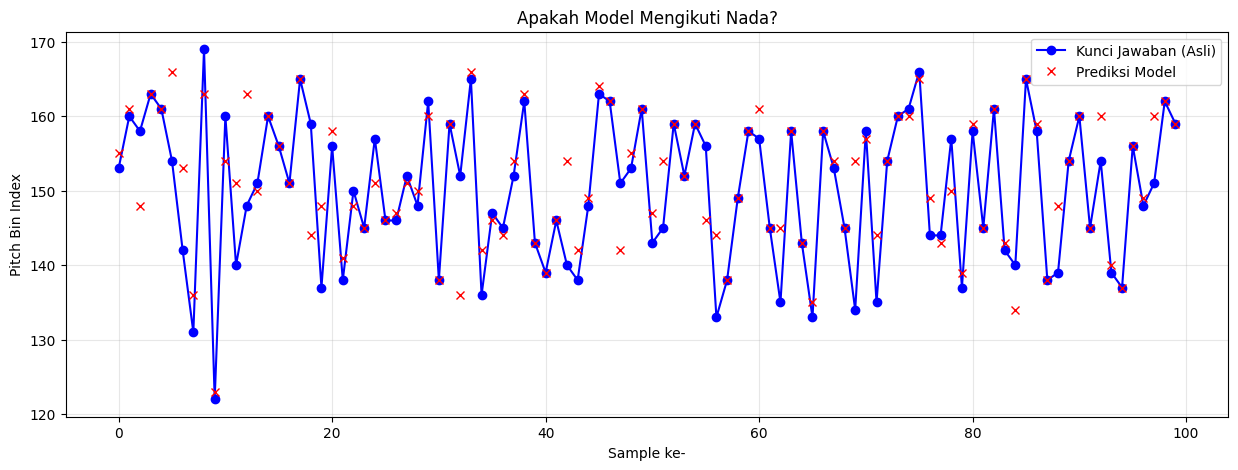

In [ ]:
#(14)
#Visualisasi Prediksi vs Asli

model.eval()
inputs, labels = next(iter(val_loader)) #Ambil 1 batch
outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

limit = 100
y_true = labels[:limit].cpu().numpy()
y_pred = predicted[:limit].cpu().numpy()

plt.figure(figsize=(15, 5))
plt.plot(y_true, label='Kunci Jawaban (Asli)', color='blue', marker='o', linestyle='-')
plt.plot(y_pred, label='Prediksi Model', color='red', marker='x', linestyle='None') #X merah
plt.title("Apakah Model Mengikuti Nada?")
plt.xlabel("Sample ke-")
plt.ylabel("Pitch Bin Index")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
import librosa

# 1. Fungsi Helper: Konversi Bin ke Nama Nada (Music Theory)
NOTES = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

def bin_to_frequency(bin_idx):
    # Kebalikan rumus: freq = 10 * 2^(cents/1200)
    cents = bin_idx * 20 # CENTS_PER_BIN
    return 10 * (2 ** (cents / 1200.0))

def frequency_to_note_name(frequency):
    if frequency == 0: return "Silence"

    # Rumus A4 = 440Hz
    h = 12 * np.log2(frequency / 440.0)
    n = round(h) + 69 # 69 adalah MIDI number untuk A4

    # Konversi ke Nama
    note_idx = n % 12
    octave = (n // 12) - 1

    note_name = NOTES[note_idx]

    # Hitung Cents Error (Seberapa fales?)
    p_hz = 440 * (2 ** ((n - 69) / 12))
    cents_error = 1200 * np.log2(frequency / p_hz)

    return f"{note_name}{octave} ({cents_error:+.1f}c)"

# 2. Ambil 1 Sampel Acak dari Validation Set
model.eval()
idx = np.random.randint(0, len(X_val)) # Ambil index acak

# Data Input
input_tensor = torch.tensor(X_val[idx]).unsqueeze(0).unsqueeze(0).to(device)
label_idx = y_val[idx]

# 3. Prediksi Model
with torch.no_grad():
    output = model(input_tensor)
    pred_idx = torch.argmax(output, dim=1).item()

# 4. Hitung Hasil
real_freq = bin_to_frequency(label_idx)
pred_freq = bin_to_frequency(pred_idx)
real_note = frequency_to_note_name(real_freq)
pred_note = frequency_to_note_name(pred_freq)

print("="*40)
print("       🎵 HASIL PREDIKSI AI 🎵")
print("="*40)
print(f"Kunci Jawaban Asli : {real_note} \t[{real_freq:.1f} Hz]")
print(f"Tebakan Model      : {pred_note} \t[{pred_freq:.1f} Hz]")
print("-" * 40)

if abs(label_idx - pred_idx) <= 3:
    print("✅ HASIL: BENAR / IN TUNE! (Akurasi Tinggi)")
else:
    print("❌ HASIL: SALAH / FALES (Perlu Latihan Lagi)")

# Putar Suaranya
print("\nPutar Audio:")
audio_data = X_val[idx]
ipd.display(ipd.Audio(audio_data, rate=16000))

       🎵 HASIL PREDIKSI AI 🎵
Kunci Jawaban Asli : G1 (-31.3c) 	[48.1 Hz]
Tebakan Model      : F#1 (+28.7c) 	[47.0 Hz]
----------------------------------------
✅ HASIL: BENAR / IN TUNE! (Akurasi Tinggi)

Putar Audio:


In [ ]:
#(15)Install Gradio
!pip install gradio

In [3]:
import gradio as gr
import torch
import torch.nn as nn
import numpy as np
import os
from collections import deque, Counter #untuk Buffer
from google.colab import drive

#MOUNT & SETUP
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

device = torch.device("cpu")

#MODEL
class VocalTunaNet(nn.Module):
    def __init__(self):
        super(VocalTunaNet, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv1d(1, 128, 51, 4, 25), nn.BatchNorm1d(128), nn.ReLU(), nn.MaxPool1d(2))
        self.conv2 = nn.Sequential(nn.Conv1d(128, 128, 51, 1, 25), nn.BatchNorm1d(128), nn.ReLU(), nn.MaxPool1d(2))
        self.conv3 = nn.Sequential(nn.Conv1d(128, 256, 51, 1, 25), nn.BatchNorm1d(256), nn.ReLU(), nn.MaxPool1d(2))
        self.conv4 = nn.Sequential(nn.Conv1d(256, 512, 51, 1, 25), nn.BatchNorm1d(512), nn.ReLU(), nn.MaxPool1d(2))
        self.fc = nn.Linear(512 * 16, 360)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.conv1(x); x = self.conv2(x); x = self.conv3(x); x = self.conv4(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = VocalTunaNet().to(device)
state_dict = torch.load('/content/drive/MyDrive/DeepLearning_Project/vocal_tuna_best.pth', map_location=device)
model.load_state_dict(state_dict)
model.eval()

NOTES = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

def bin_to_note_streaming(bin_idx):
    if bin_idx == 0: return "Silence", 0
    cents = bin_idx * 20
    freq = 10 * (2 ** (cents / 1200.0))
    midi = 69 + 12 * np.log2(freq / 440.0)
    note_idx = int(np.round(midi)) % 12
    note_name = NOTES[note_idx]

    exact_midi = midi
    nearest_midi = round(midi)
    cents_error = (exact_midi - nearest_midi) * 100
    return note_name, cents_error

prediction_buffer = deque(maxlen=8)

def live_tuner_stable(audio_chunk):
    if audio_chunk is None: return "..."

    sr, y = audio_chunk
    if len(y.shape) > 1: y = np.mean(y, axis=1) # Stereo to Mono

    #Normalisasi & Padding
    max_val = np.max(np.abs(y))
    if max_val > 0: y = y / max_val
    else: return "🔇 Hening"

    target_len = 1024
    if len(y) < target_len: y = np.pad(y, (0, target_len - len(y)))
    else: y = y[-target_len:]

    #Prediksi
    tensor_input = torch.tensor(y, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(tensor_input)
        current_bin = torch.argmax(output, dim=1).item()

    #Masukkan hasil sekarang ke antrian buffer
    prediction_buffer.append(current_bin)

    #Lakukan Voting (Cari bin yang paling sering muncul di buffer)
    #Ini mencegah error sesaat (glitch)
    if len(prediction_buffer) > 0:
        stable_bin, _ = Counter(prediction_buffer).most_common(1)[0]
    else:
        stable_bin = current_bin

    #Konversi Bin Stabil ke Nama Nada
    note_name, error = bin_to_note_streaming(stable_bin)

    if note_name == "Silence": return "..."

    if abs(error) < 15: indicator = "✅ TEPAT!"
    elif error > 0:     indicator = f"⬇️ Ketinggian"
    else:               indicator = f"⬆️ Kerendahan"

    return f"🎵 {note_name}\n{indicator}"

#RUN
demo = gr.Interface(
    fn=live_tuner_stable,
    inputs=gr.Audio(sources=["microphone"], type="numpy", streaming=True),
    outputs=gr.Label(label="Stabilized Output", num_top_classes=1),
    live=True,
    title="ResonAI Live Tuner",
    description="Bernyanyilah! Indikatornya akan berubah secara real-time (Latency bergantung pada koneksi internet)."
)

demo.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://7c45e8226f9504d0e4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://7c45e8226f9504d0e4.gradio.live
